In [16]:
import os
from pathlib import Path
import numpy as np
import time
from scipy.optimize import minimize
from simsopt._core.optimizable import load
from simsopt.geo import ArclengthVariation
from simsopt.geo.surfacerzfourier import SurfaceRZFourier
from simsopt.objectives.fluxobjective import SquaredFlux
from simsopt.objectives.utilities import QuadraticPenalty
from simsopt.geo.curve import curves_to_vtk, create_equally_spaced_curves, create_equally_spaced_windowpane_curves
from simsopt.field.biotsavart import BiotSavart
from simsopt.field.coil import Current, coils_via_symmetries, ScaledCurrent, apply_symmetries_to_curves
from simsopt.geo.curveobjectives import CurveLength, CurveCurveDistance, \
    MeanSquaredCurvature, LpCurveCurvature, CurveSurfaceDistance, LinkingNumber

import matplotlib.pyplot as plt

from simsopt.geo import CurveCWSFourier
from simsopt.geo import ProjectedEnclosedArea, ProjectedCurveCurveDistance, ProjectedCurveConvexity, DirectedFacingPort

%matplotlib widget

In [17]:
# Number of unique coil shapes, i.e. the number of coils per half field period:
# (Since the configuration has nfp = 2, multiply by 4 to get the total number of coils.)
ncoils = 5

# Major radius for the initial circular coils:
R0 = 1.0

# Minor radius for the initial circular coils:
R1 = 0.5

# Number of Fourier modes describing each Cartesian component of each coil:
order = 7

WP_WEIGHT_SCALE = 1

# Weight on the curve lengths in the objective function. We use the `Weight`
# class here to later easily adjust the scalar value and rerun the optimization
# without having to rebuild the objective.
LENGTH_WEIGHT = 0.0156434465

# Threshold and weight for the coil-to-coil distance penalty in the objective function:
CC_THRESHOLD = 0.08
CC_WEIGHT = 156.434465

# Threshold and weight for the coil-to-surface distance penalty in the objective function:
CS_THRESHOLD = 0.12
CS_WEIGHT = 1564.34465

# Threshold and weight for the curvature penalty in the objective function:
CURVATURE_THRESHOLD = 12.
CURVATURE_WEIGHT = 0.000000156434465

# Threshold and weight for the mean squared curvature penalty in the objective function:
MSC_THRESHOLD = 11
MSC_WEIGHT = 1.10e-08

# Port size relevant weights
wport = 1E-4
wdd = 1E6
#wco = 1E1
#wph = 1E3
warc = 1E-1
wufp = 1E-1

# Number of iterations to perform:
MAXITER =  1E4

# File for the desired boundary magnetic surface:
filename = 'input.LandremanPaul2021_QH'

# Directory for output
OUT_DIR = f"./output/"
os.makedirs(OUT_DIR, exist_ok=True)

In [18]:
# Initialize the boundary magnetic surface:
nphi = 34
ntheta = 32
s = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)
fulls = SurfaceRZFourier.from_vmec_input(filename, nphi=nphi, ntheta=ntheta)

# Create the initial coils:
base_tf_curves = create_equally_spaced_curves(ncoils, s.nfp, stellsym=True, R0=R0, R1=R1, order=order, numquadpoints=512) 
base_tf_currents = [Current(-1e4) for i in range(ncoils)]

base_curves = base_tf_curves
base_currents = base_tf_currents

coils = coils_via_symmetries(base_curves, base_currents, s.nfp, True)

for c in coils:
    c.unfix_all()


bs = BiotSavart(coils)
bs.set_points(s.gamma().reshape((-1, 3)))

curves = [c.curve for c in coils]
curves_to_vtk(curves, OUT_DIR + "curves_init")
pointData = {"B_N": np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)[:, :, None]}
s.to_vtk(OUT_DIR + "surf_init", extra_data=pointData)

In [19]:
#Define one port
order = 1
qpts = 64
curve_cws = CurveCWSFourier(
    qpts,
    order,
    fulls
)
nfp = s.nfp
dphi = 1/(2*nfp) * 1/ncoils
iphi0 = 0
curve_cws.set('phic(0)', iphi0*dphi)
curve_cws.set('phic(1)', dphi/3.0)
curve_cws.set('thetac(0)', 0.0)
curve_cws.set('thetas(1)', 0.05)

Text(0, 0.5, 'z')

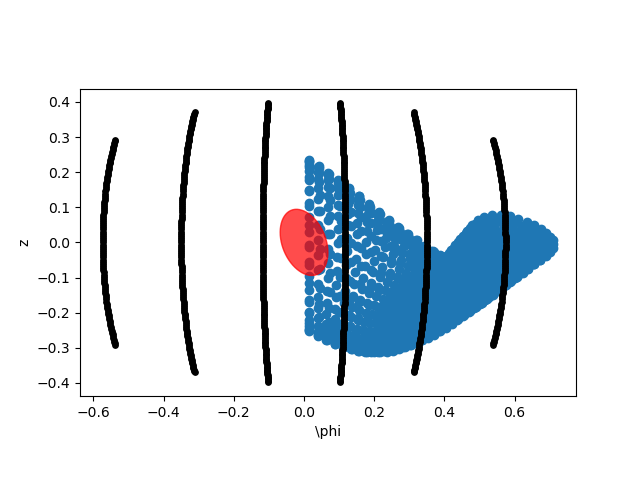

In [20]:
def project(x, x0):
    phic = np.arctan2(x0[1], x0[0])
    unit_normal = np.array([np.cos(phic), np.sin(phic), np.zeros(phic.shape)])
    unit_tangent = np.array([-np.sin(phic), np.cos(phic), np.zeros(phic.shape)])
    unit_z = np.array([np.zeros(phic.shape), np.zeros(phic.shape), np.ones(phic.shape)])

    M = np.array([unit_normal,unit_tangent,unit_z]).transpose()
    invM = np.linalg.inv(M)
    
    return np.einsum('ij,...j->...i',invM,x-x0)

x0 = np.mean(curve_cws.gamma(),axis=0)
gproj = project(s.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

gport = project(curve_cws.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=0.7)

for c in curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='k', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('\phi')
ax.set_ylabel('z')

In [6]:
# Define the individual terms objective function:
Jf = SquaredFlux(s, bs)
Jls = [CurveLength(c) for c in base_curves]
Jccdist = CurveCurveDistance(curves, CC_THRESHOLD, num_basecurves=ncoils)
Jcsdist = CurveSurfaceDistance(curves, s, CS_THRESHOLD)
Jcs = [LpCurveCurvature(c, 2, CURVATURE_THRESHOLD) for c in base_curves]
Jmscs = [MeanSquaredCurvature(c) for c in base_curves]
linkNum = LinkingNumber(base_tf_curves)

# Port relavant penalties
Jxyarea = ProjectedEnclosedArea( curve_cws, projection='zphi' )
Jccxydist = ProjectedCurveCurveDistance( curves, curve_cws, 0.05, projection='zphi' )
Jconvex = ProjectedCurveConvexity( curve_cws, projection='zphi' )
Jarc = ArclengthVariation( curve_cws )
Jufp = DirectedFacingPort(curve_cws, projection='r')
Jport = -1 * Jxyarea + wdd * Jccxydist + warc * Jarc + wufp * Jufp #+ wco * Jconvex


# Form the total objective function. To do this, we can exploit the
# fact that Optimizable objects with J() and dJ() functions can be
# multiplied by scalars and added:
JF = Jf \
    + LENGTH_WEIGHT * QuadraticPenalty(sum(Jls), 2.6*ncoils) \
    + CC_WEIGHT * Jccdist \
    + CS_WEIGHT * Jcsdist \
    + CURVATURE_WEIGHT * sum(Jcs) \
    + MSC_WEIGHT * sum(QuadraticPenalty(J, MSC_THRESHOLD) for J in Jmscs) \
    + QuadraticPenalty(linkNum, 0.1) \
    + wport * Jport

# We don't have a general interface in SIMSOPT for optimisation problems that
# are not in least-squares form, so we write a little wrapper function that we
# pass directly to scipy.optimize.minimize


def fun(dofs):
    JF.x = dofs
    J = JF.J()
    grad = JF.dJ()
    jf = Jf.J()
    BdotN = np.mean(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    MaxBdotN = np.max(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    mean_AbsB = np.mean(bs.AbsB())

    
    A = Jxyarea.J()
    CC = Jccxydist.J()
    arc = Jarc.J()
    #convex = Jconvex.J()
    
    outstr = f"J={J:.1e}, Jf={jf:.1e}, ⟨B·n⟩={BdotN:.1e}"
    cl_string = ", ".join([f"{J.J():.1f}" for J in Jls])
    kap_string = ", ".join(f"{np.max(c.kappa()):.1f}" for c in base_curves)
    msc_string = ", ".join(f"{J.J():.1f}" for J in Jmscs)
    outstr += f", Len=sum([{cl_string}])={sum(J.J() for J in Jls):.1f}, ϰ=[{kap_string}], ∫ϰ²/L=[{msc_string}]"
    outstr += f", C-C-Sep={Jccdist.shortest_distance():.2f}, C-S-Sep={Jcsdist.shortest_distance():.2f}"
    outstr += f", ║∇J║={np.linalg.norm(grad):.1e}"
    outstr += f", ⟨B·n⟩/|B|={BdotN/mean_AbsB:.1e}"
    outstr += f", (Max B·n)/|B|={MaxBdotN/mean_AbsB:.1e}"
    outstr += f", Link Number = {linkNum.J()}\n"
    outstr += f"Jport={Jport.J():.2E}, Area={A:.2E}, Coil-coil dist={CC:.2E}, Arc penalty={arc:.2E}"#, Convex={convex:.2E}"
    print(outstr)
    return J, grad

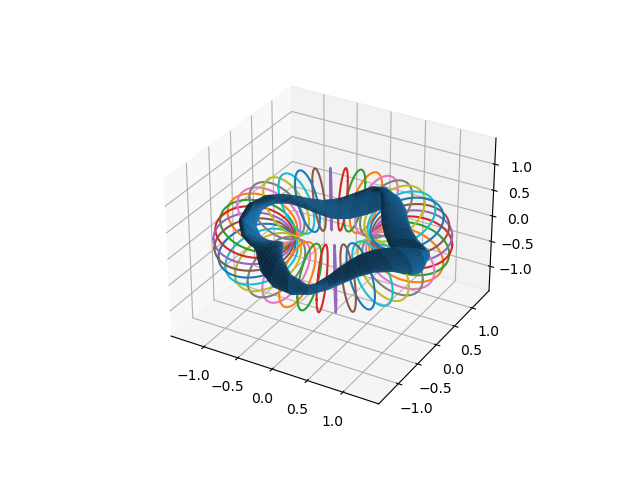

In [7]:
fulls.plot(show=False, close=True)
ax = plt.gca()
for c in bs.coils:
    c.curve.plot(ax=ax, show=False)

Text(0.5, 0, '$\\theta$')

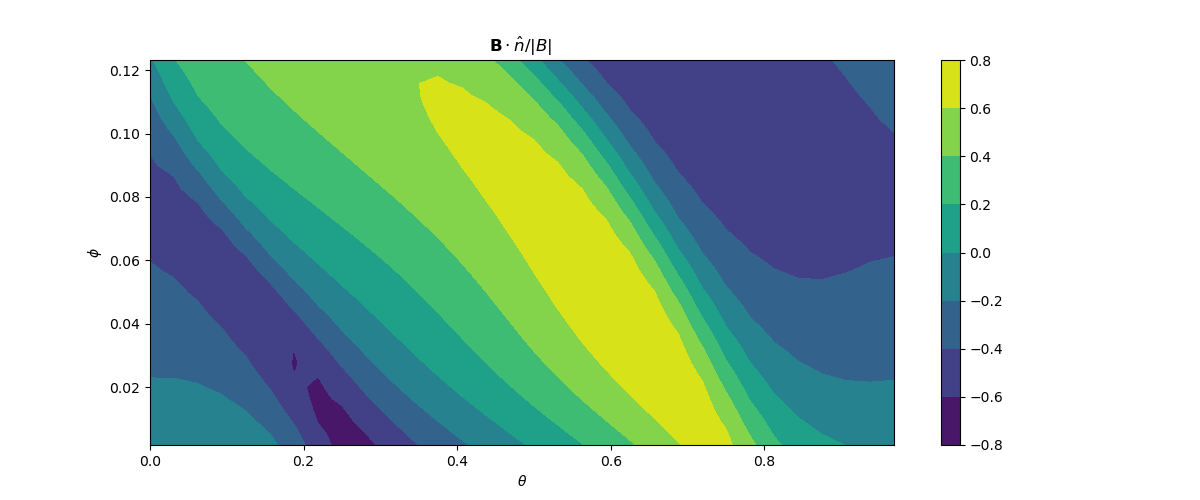

In [8]:
surf = s
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(surf.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(12,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)
ax.set_title(r'$\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')


################################################################################
### Perform a Taylor test ######################################################
################################################################################

J=6.7e-02, Jf=4.3e-03, ⟨B·n⟩=3.2e-02, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1])=15.7, ϰ=[2.0, 2.0, 2.0, 2.0, 2.0], ∫ϰ²/L=[4.0, 4.0, 4.0, 4.0, 4.0], C-C-Sep=0.08, C-S-Sep=0.16, ║∇J║=4.2e-01, ⟨B·n⟩/|B|=3.9e-01, (Max B·n)/|B|=9.1e-01, Link Number = 1.8187906185185628e-16
Jport=-7.21E-03, Area=8.05E-03, Coil-coil dist=0.00E+00, Arc penalty=8.37E-03
J=6.7e-02, Jf=4.3e-03, ⟨B·n⟩=3.2e-02, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1])=15.7, ϰ=[2.6, 2.7, 2.6, 2.7, 2.6], ∫ϰ²/L=[4.1, 4.1, 4.0, 4.1, 4.0], C-C-Sep=0.07, C-S-Sep=0.16, ║∇J║=4.3e-01, ⟨B·n⟩/|B|=3.9e-01, (Max B·n)/|B|=9.1e-01, Link Number = 4.526594981727027e-15
Jport=-7.62E-03, Area=8.32E-03, Coil-coil dist=0.00E+00, Arc penalty=7.01E-03
J=6.6e-02, Jf=4.3e-03, ⟨B·n⟩=3.2e-02, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1])=15.

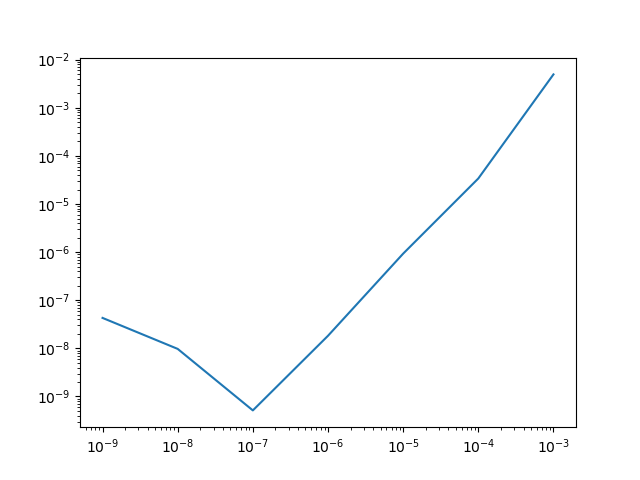

In [9]:
print("""
################################################################################
### Perform a Taylor test ######################################################
################################################################################
""")
f = fun
dofs = JF.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
myerr = []
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh)

plt.figure()
plt.loglog(myeps, np.abs(myerr))

In [10]:
res = minimize(fun, dofs, jac=True, method='L-BFGS-B', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-12)

J=6.7e-02, Jf=4.3e-03, ⟨B·n⟩=3.2e-02, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1])=15.7, ϰ=[2.0, 2.0, 2.0, 2.0, 2.0], ∫ϰ²/L=[4.0, 4.0, 4.0, 4.0, 4.0], C-C-Sep=0.08, C-S-Sep=0.16, ║∇J║=4.2e-01, ⟨B·n⟩/|B|=3.9e-01, (Max B·n)/|B|=9.1e-01, Link Number = 1.8187906185185628e-16
Jport=-7.21E-03, Area=8.05E-03, Coil-coil dist=0.00E+00, Arc penalty=8.37E-03
J=2.8e+00, Jf=2.8e-03, ⟨B·n⟩=1.5e-02, Len=sum([1.2, 1.2, 1.2, 1.2, 1.2])=5.8, ϰ=[11.5, 6.6, 7.6, 8.4, 12.2], ∫ϰ²/L=[42.5, 30.2, 30.5, 30.9, 42.4], C-C-Sep=0.10, C-S-Sep=0.00, ║∇J║=1.4e+01, ⟨B·n⟩/|B|=3.7e-01, (Max B·n)/|B|=8.3e+00, Link Number = 1.1965497787414226e-15
Jport=-7.66E-03, Area=8.41E-03, Coil-coil dist=0.00E+00, Arc penalty=7.58E-03
J=5.9e-02, Jf=4.3e-03, ⟨B·n⟩=3.2e-02, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1])=15.5, ϰ=[2.0, 2.0, 2.0, 2.0, 2.0], ∫ϰ²/L=[4.1, 4.1, 4.1, 4.1, 4.1], C-C-Sep=0.08, C-S-Sep=0.15, ║∇J║=3.9e-01, ⟨B·n⟩/|B|=3.9e-01, (Max B·n)/|B|=9.1e-01, Link Number = 3.0329483240534533e-15
Jport=-7.22E-03, Area=8.06E-03, Coil-coil dist=0.00E

In [11]:
print(res.message)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


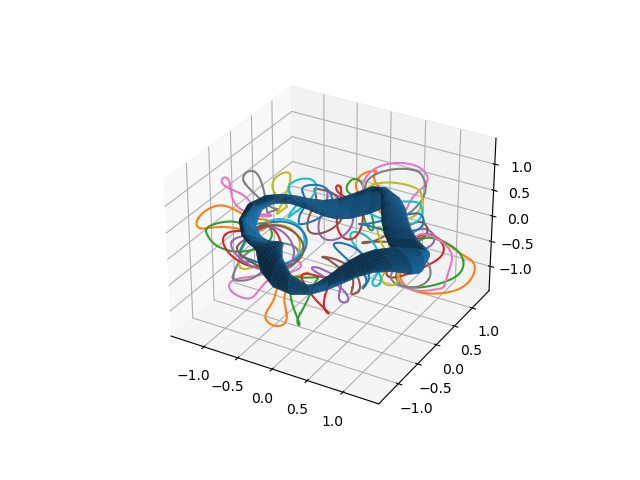

In [12]:
fulls.plot(show=False, close=True)
ax = plt.gca()
for c in bs.coils:
    c.curve.plot(ax=ax, show=False)

Text(0.5, 0, '$\\theta$')

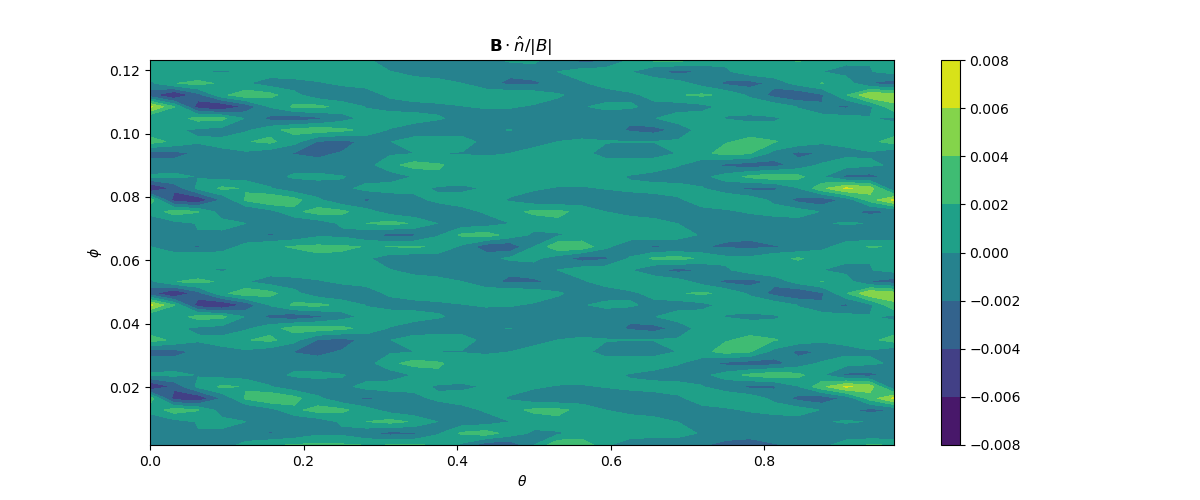

In [13]:
surf = s
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(fulls.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * fulls.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(12,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)
ax.set_title(r'$\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')

Text(0, 0.5, 'z')

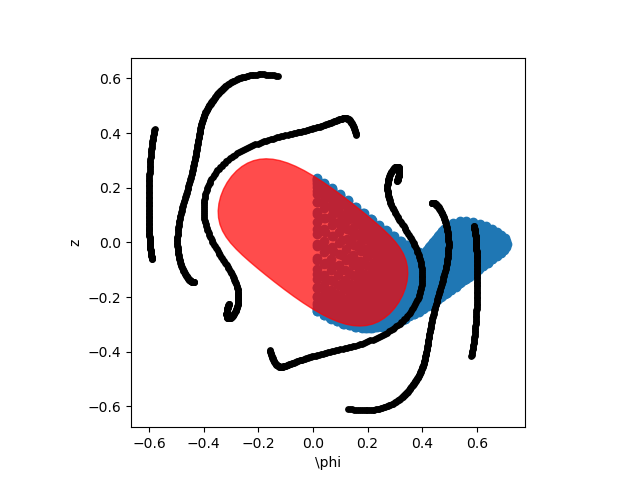

In [14]:
x0 = np.mean(curve_cws.gamma(),axis=0)
gproj = project(s.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

gport = project(curve_cws.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=0.7)

for c in curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='k', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('\phi')
ax.set_ylabel('z')

In [15]:
curves_to_vtk(curves, OUT_DIR + f"curves_wport={wport:.2E}_phi0={phi0:.2f}")
pointData = {"B_N": np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)[:, :, None]}
s.to_vtk(OUT_DIR + "surf_opt_short", extra_data=pointData)
bs.save(OUT_DIR + f'biotsavart_wport={wport:.2E}_phi0={phi0:.2f}.json');